In [1]:
import os
import sys
import subprocess
import datetime as dt
import itertools
import numpy as np
import xarray as xr
from dask.distributed import Client, LocalCluster
import dask.array as da
import matplotlib.pyplot as plt
from MHW_daily_calcs import *

In [2]:
mdir='/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/data/predictions/cansipsv3_daily/CanESM5'
dd=1
hh=0
fnameCanESMdaily=lambda yyyy, mm:f"{mdir}/joined/cwao_CanESM5.1p1bc-v20240611_hindcast_S{yyyy:04}{mm:02}{dd:02}{hh:02}_ocean_1d_surface_tso.nc"


In [3]:
fname_old=fnameCanESMdaily(1998,1)
fname_new=fnameCanESMdaily(1998,2)

In [4]:
fold=xr.open_mfdataset(fname_old,decode_times=False)
fnew=xr.open_mfdataset(fname_new,decode_times=False)

In [5]:
fold.tso.encoding

{'dtype': dtype('float64'),
 'zlib': True,
 'szip': False,
 'zstd': False,
 'bzip2': False,
 'blosc': False,
 'shuffle': False,
 'complevel': 6,
 'fletcher32': False,
 'contiguous': False,
 'chunksizes': (5, 54, 45, 90),
 'preferred_chunks': {'r': 5, 'leadtime': 54, 'lat': 45, 'lon': 90},
 'source': '/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/data/predictions/cansipsv3_daily/CanESM5/joined/cwao_CanESM5.1p1bc-v20240611_hindcast_S1998010100_ocean_1d_surface_tso.nc',
 'original_shape': (20, 215, 180, 360),
 'missing_value': np.float64(1e+20),
 '_FillValue': np.float64(1e+20),
 'coordinates': 'reftime realization time leadtime lat lon'}

In [6]:
fnew.tso.encoding

{'dtype': dtype('float64'),
 'zlib': True,
 'szip': False,
 'zstd': False,
 'bzip2': False,
 'blosc': False,
 'shuffle': False,
 'complevel': 6,
 'fletcher32': False,
 'contiguous': False,
 'chunksizes': (5, 54, 45, 90),
 'preferred_chunks': {'r': 5, 'leadtime': 54, 'lat': 45, 'lon': 90},
 'source': '/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/data/predictions/cansipsv3_daily/CanESM5/joined/cwao_CanESM5.1p1bc-v20240611_hindcast_S1998020100_ocean_1d_surface_tso.nc',
 'original_shape': (20, 215, 180, 360),
 'missing_value': np.float64(1e+20),
 '_FillValue': np.float64(1e+20),
 'coordinates': 'reftime realization time leadtime lat lon'}

In [7]:
fold.tso

<xarray.DataArray 'tso' (r: 20, leadtime: 215, lat: 180, lon: 360)> Size: 2GB
dask.array<open_dataset-tso, shape=(20, 215, 180, 360), dtype=float64, chunksize=(5, 54, 45, 90), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * leadtime  (leadtime) float64 2kB 15.0 39.0 63.0 ... 5.127e+03 5.151e+03
  * lon       (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    reftime   float64 8B ...
    time      (leadtime) float64 2kB dask.array<chunksize=(215,), meta=np.ndarray>
Dimensions without coordinates: r
Attributes:
    cell_methods:   leadtime: point
    grid_mapping:   hcrs
    long_name:      Sea Surface Temperature
    standard_name:  sea_surface_temperature
    units:          K

In [8]:
fnew.tso

<xarray.DataArray 'tso' (r: 20, leadtime: 215, lat: 180, lon: 360)> Size: 2GB
dask.array<open_dataset-tso, shape=(20, 215, 180, 360), dtype=float64, chunksize=(5, 54, 45, 90), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * leadtime  (leadtime) float64 2kB 15.0 39.0 63.0 ... 5.127e+03 5.151e+03
  * lon       (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    reftime   float64 8B ...
    time      (leadtime) float64 2kB dask.array<chunksize=(215,), meta=np.ndarray>
Dimensions without coordinates: r
Attributes:
    cell_methods:   leadtime: point
    grid_mapping:   hcrs
    long_name:      Sea Surface Temperature
    standard_name:  sea_surface_temperature
    units:          K

In [9]:
fnew.time

<xarray.DataArray 'time' (leadtime: 215)> Size: 2kB
dask.array<open_dataset-time, shape=(215,), dtype=float64, chunksize=(215,), chunktype=numpy.ndarray>
Coordinates:
  * leadtime  (leadtime) float64 2kB 15.0 39.0 63.0 ... 5.127e+03 5.151e+03
    reftime   float64 8B ...
    time      (leadtime) float64 2kB dask.array<chunksize=(215,), meta=np.ndarray>
Attributes:
    long_name:      Verification time of the forecast
    units:          hours since 1998-02-01T00:00:00
    calendar:       gregorian
    standard_name:  time

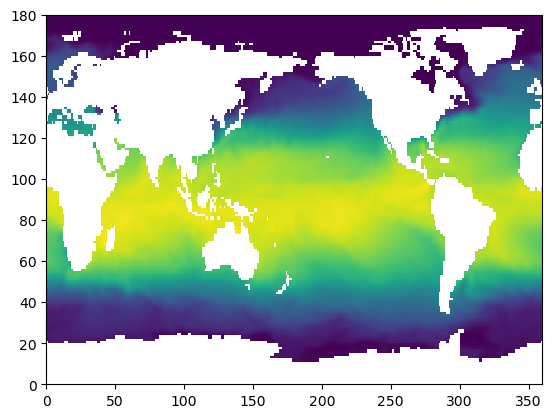

In [10]:
plt.pcolormesh(fnew.tso[0,0,:,:])

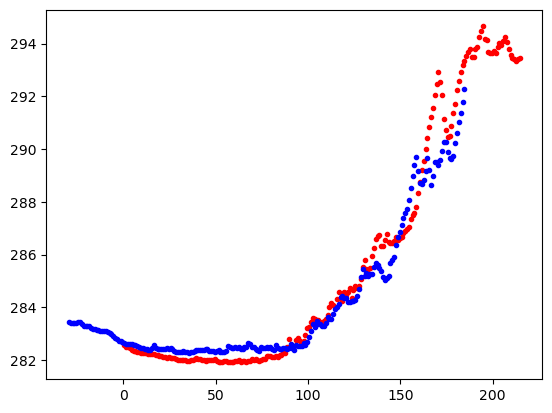

In [11]:
plt.plot(fnew.time/24,fnew.tso[0,:,130,200],'r.')
plt.plot(fold.time/24-30,fold.tso[0,:,130,200],'b.')

In [12]:
for yyyy,mm in [ (2009,12),(2011,12),(2017,10),(2019,10),(2021,10),(2023,10)]:#ok:(1998,2),(2000,2),(2002,2),(2004,2),(2005,12),(2007,12),
    el=fnameCanESMdaily(yyyy, mm)
    ff=xr.open_dataset(el,decode_times=False)
    print(yyyy,mm,np.sum(~np.isnan(ff.tso.values)))
    ff.close()

2009 12 179993700
2011 12 179993700
2017 10 179993700
2019 10 179993700
2021 10 179993700
2023 10 179993700


In [5]:
### detrended anomalies
fn=fnameCanESMAnomDetrByLead(workdir,1993,2023,214,120)
fex=xr.open_mfdataset(fn)

In [6]:
fex

<xarray.Dataset> Size: 1GB
Dimensions:   (lat: 60, lon: 360, reftime: 378, r: 20)
Coordinates:
  * lat       (lat) float64 480B 30.5 31.5 32.5 33.5 ... 86.5 87.5 88.5 89.5
    leadtime  timedelta64[ns] 8B ...
  * lon       (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * reftime   (reftime) datetime64[ns] 3kB 1993-01-01 1993-02-01 ... 2024-06-01
  * r         (r) int64 160B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Data variables:
    sst_an    (reftime, r, lat, lon) float64 1GB dask.array<chunksize=(378, 20, 60, 360), meta=np.ndarray>

In [7]:
fex.sst_an

<xarray.DataArray 'sst_an' (reftime: 378, r: 20, lat: 60, lon: 360)> Size: 1GB
dask.array<open_dataset-sst_an, shape=(378, 20, 60, 360), dtype=float64, chunksize=(378, 20, 60, 360), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 480B 30.5 31.5 32.5 33.5 ... 86.5 87.5 88.5 89.5
    leadtime  timedelta64[ns] 8B ...
  * lon       (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * reftime   (reftime) datetime64[ns] 3kB 1993-01-01 1993-02-01 ... 2024-06-01
  * r         (r) int64 160B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19

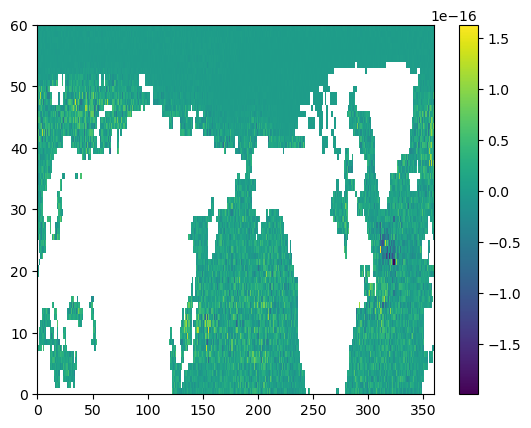

In [11]:
plt.pcolormesh(fex.sst_an.mean(dim='reftime').mean(dim='r'))
plt.colorbar()